In [1]:
# Import required libraries
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from data_loader import NSLKDDDataLoader
from config import ATTACK_CATEGORY_MAP, COLUMN_NAMES

warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Dataset

We'll load the NSL-KDD dataset using our custom data loader.

In [2]:
# Initialize data loader
loader = NSLKDDDataLoader()

# Load and preprocess data
print("Loading NSL-KDD dataset...")
X_train, y_train, X_val, y_val, X_test, y_test = loader.load_and_preprocess()

print(f"\n✓ Data loaded successfully!")
print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Total features: {X_train.shape[1]}")

Loading NSL-KDD dataset...

✓ Data loaded successfully!
Training samples: 100,778
Validation samples: 25,195
Test samples: 22,544
Total features: 41


## 2. Class Distribution Analysis

Understanding the distribution of threat severity scores is critical for model training.

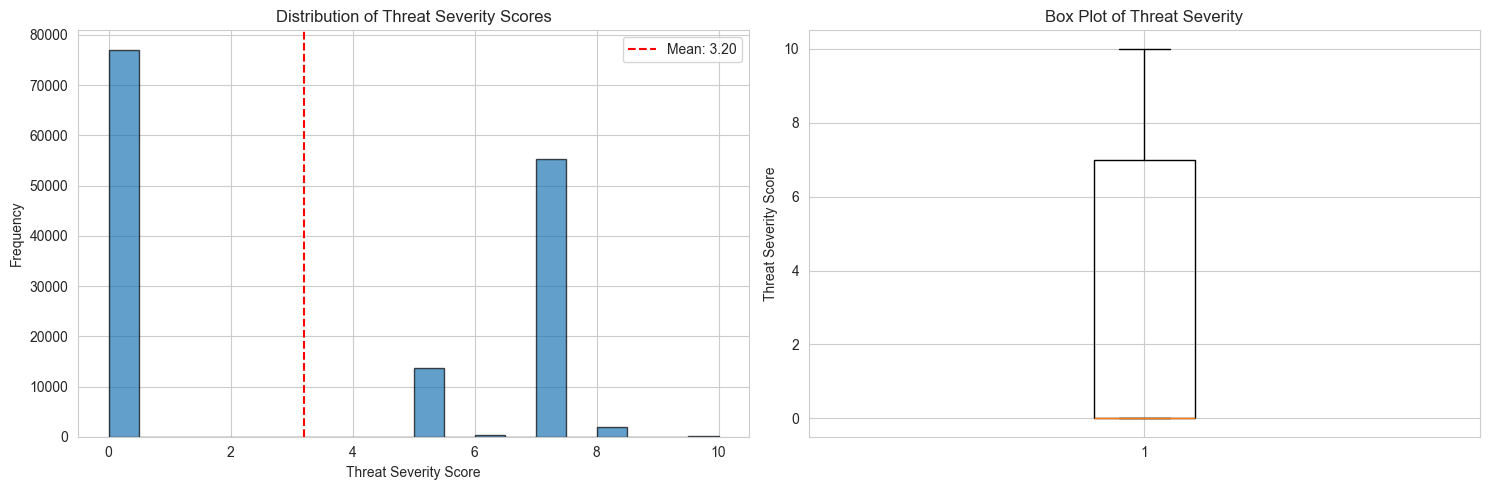


Threat Severity Statistics:
count    148517.000000
mean          3.196658
std           3.368887
min           0.000000
25%           0.000000
50%           0.000000
75%           7.000000
max          10.000000
Name: threat_severity, dtype: float64

Value Counts:
threat_severity
0     77054
5     13758
6       319
7     55239
8      2026
9        37
10       84
Name: count, dtype: int64


In [3]:
# Combine all sets for comprehensive analysis
y_all = pd.concat([y_train, y_val, y_test])

# Plot threat severity distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(y_all, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Threat Severity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Threat Severity Scores')
axes[0].axvline(y_all.mean(), color='red', linestyle='--', label=f'Mean: {y_all.mean():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(y_all, vert=True)
axes[1].set_ylabel('Threat Severity Score')
axes[1].set_title('Box Plot of Threat Severity')

plt.tight_layout()
plt.show()

# Statistics
print("\nThreat Severity Statistics:")
print(y_all.describe())
print(f"\nValue Counts:")
print(y_all.value_counts().sort_index())

## 3. Feature Statistics

Let's examine the statistical properties of our features.

In [4]:
# Combine features
X_all = pd.concat([X_train, X_val, X_test])

# Basic statistics
print("Feature Statistics (first 10 features):")
print(X_all.iloc[:, :10].describe())

# Check for missing values
missing = X_all.isnull().sum()
if missing.any():
    print(f"\nMissing values found:")
    print(missing[missing > 0])
else:
    print("\n✓ No missing values detected")

# Data types
print(f"\nData types:")
print(X_all.dtypes.value_counts())

Feature Statistics (first 10 features):
            duration  protocol_type        service           flag  \
count  148517.000000  148517.000000  148517.000000  148517.000000   
mean      276.779305       1.055751      31.727048       6.963930   
std      2460.683131       0.422304      16.291494       2.774951   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000      20.000000       5.000000   
50%         0.000000       1.000000      24.000000       9.000000   
75%         0.000000       1.000000      49.000000       9.000000   
max     57715.000000       2.000000      69.000000      10.000000   

          src_bytes     dst_bytes           land  wrong_fragment  \
count  1.485170e+05  1.485170e+05  148517.000000   148517.000000   
mean   4.022795e+04  1.708885e+04       0.000215        0.020523   
std    5.409612e+06  3.703525e+06       0.014677        0.240069   
min    0.000000e+00  0.000000e+00       0.000000        0.000000  

## 4. Attack vs Normal Traffic Analysis

Compare characteristics of normal traffic vs attacks.

Traffic Distribution:
Normal: 77,054 (51.9%)
Attack: 71,463 (48.1%)


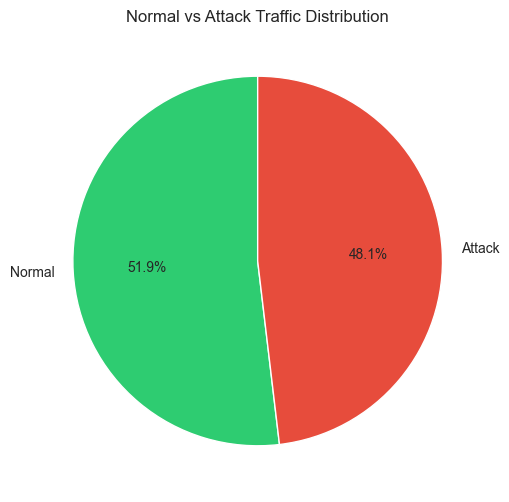

In [5]:
# Create binary labels
is_attack = (y_all > 0).astype(int)

# Count distribution
attack_counts = is_attack.value_counts()
print("Traffic Distribution:")
print(f"Normal: {attack_counts[0]:,} ({100*attack_counts[0]/len(is_attack):.1f}%)")
print(f"Attack: {attack_counts[1]:,} ({100*attack_counts[1]/len(is_attack):.1f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#2ecc71', '#e74c3c']
ax.pie(attack_counts.values, labels=['Normal', 'Attack'], autopct='%1.1f%%', 
       colors=colors, startangle=90)
ax.set_title('Normal vs Attack Traffic Distribution')
plt.show()

## 5. Feature Correlations

Identify highly correlated features that might impact threat severity.

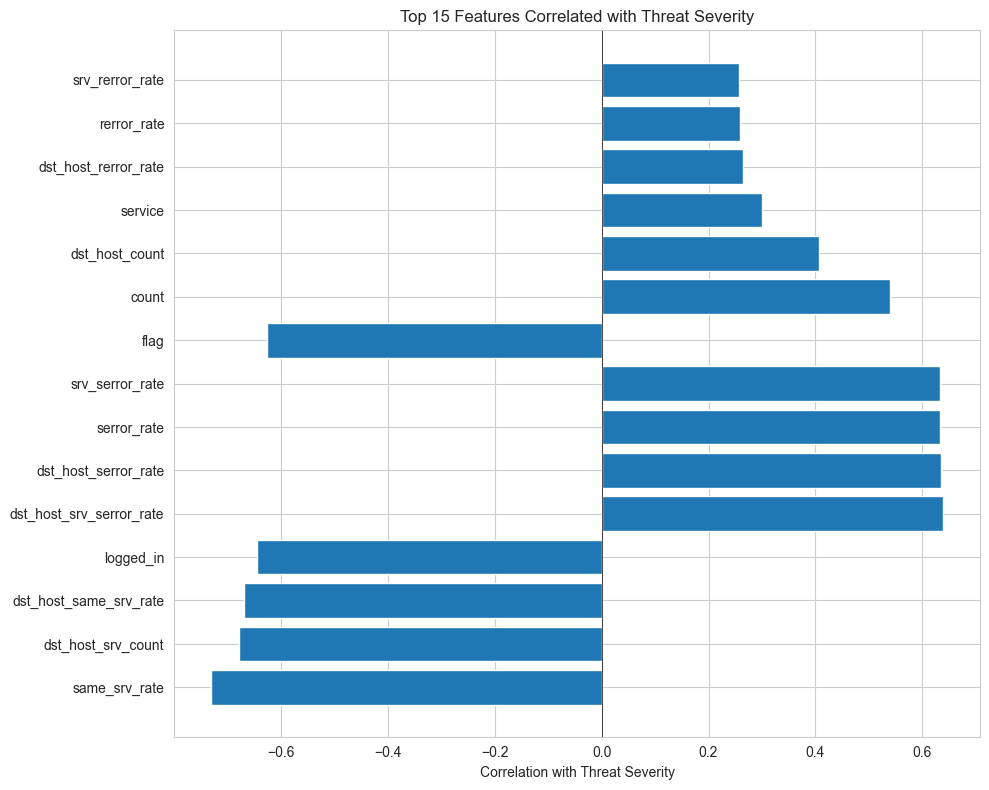


Top 10 Features by Correlation:
                     feature  correlation
28             same_srv_rate    -0.730821
32        dst_host_srv_count    -0.678828
33    dst_host_same_srv_rate    -0.669259
11                 logged_in    -0.645050
38  dst_host_srv_serror_rate     0.639265
37      dst_host_serror_rate     0.635492
24               serror_rate     0.633655
25           srv_serror_rate     0.632092
3                       flag    -0.625107
22                     count     0.540320


In [6]:
# Calculate correlations with target
feature_target_corr = pd.DataFrame({
    'feature': X_all.columns,
    'correlation': [X_all[col].corr(y_all) for col in X_all.columns]
})
feature_target_corr['abs_correlation'] = feature_target_corr['correlation'].abs()
feature_target_corr = feature_target_corr.sort_values('abs_correlation', ascending=False)

# Plot top 15 correlated features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_target_corr.head(15)
ax.barh(range(len(top_features)), top_features['correlation'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Correlation with Threat Severity')
ax.set_title('Top 15 Features Correlated with Threat Severity')
ax.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\nTop 10 Features by Correlation:")
print(feature_target_corr.head(10)[['feature', 'correlation']])

## 6. Feature Distributions

Visualize distributions of key features.

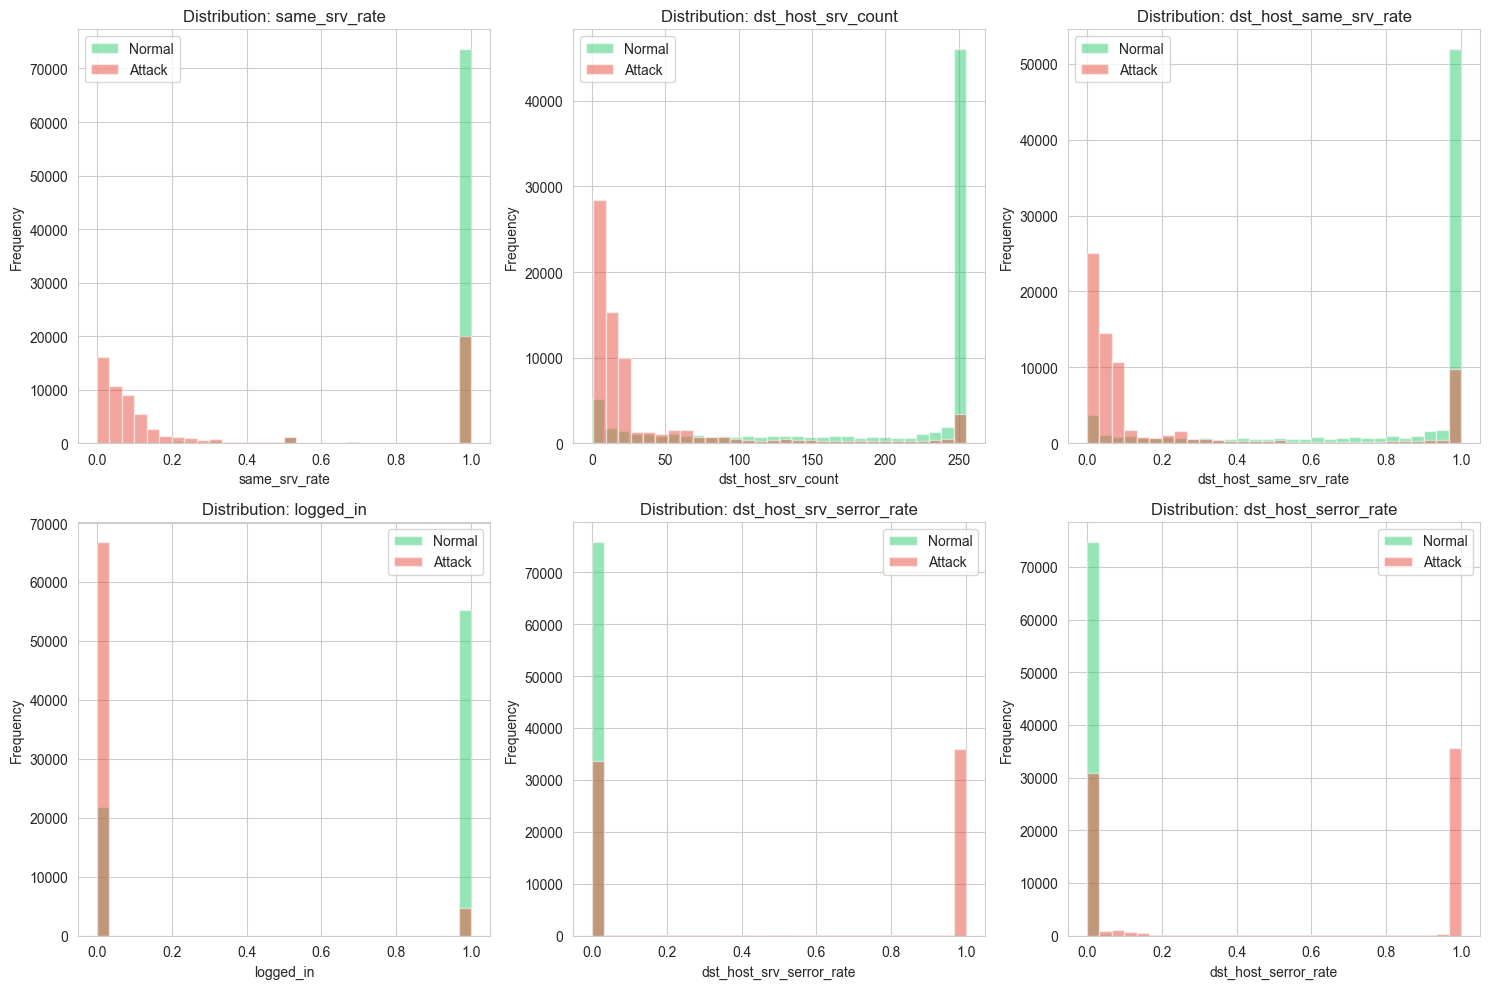

In [7]:
# Select top correlated features
top_6_features = feature_target_corr.head(6)['feature'].tolist()

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    
    # Separate by attack vs normal
    normal_data = X_all.loc[is_attack == 0, feature]
    attack_data = X_all.loc[is_attack == 1, feature]
    
    # Plot histograms
    ax.hist(normal_data, bins=30, alpha=0.5, label='Normal', color='#2ecc71')
    ax.hist(attack_data, bins=30, alpha=0.5, label='Attack', color='#e74c3c')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution: {feature}')
    ax.legend()

plt.tight_layout()
plt.show()

## 7. Key Insights and Conclusions

### Findings:

1. **Class Imbalance**: The dataset shows imbalance between normal and attack traffic
   - This will require careful handling during model training (e.g., class weights)

2. **Feature Correlations**: Several features show strong correlation with threat severity
   - These will be important for model predictions
   - Feature engineering can create additional informative features

3. **Feature Distributions**: Attack traffic shows distinct patterns compared to normal
   - Clear separation in key features enables effective classification
   - Some features show multimodal distributions

### Next Steps:

1. Engineer domain-specific security features (notebook 02)
2. Train multiple models and compare performance (notebook 03)
3. Optimize thresholds for different operational SLOs (notebook 06)
4. Deploy production-ready model with monitoring

### Model Training Considerations:

- Use stratified sampling to handle class imbalance
- Apply feature scaling for gradient-based models
- Consider ensemble methods (XGBoost, LightGBM)
- Implement SHAP for explainability

In [ ]:
# Save processed data for next notebooks
print("\n✓ EDA complete!")
print(f"\nDataset ready for model training:")
print(f"  - Features: {X_train.shape[1]}")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Class balance: {100*attack_counts[1]/(attack_counts[0]+attack_counts[1]):.1f}% attacks")